# Tutorial: STHD Training

### This is an end-to-end tutorial to demonstrate how to fit the STHD model on a given Visium HD patch. 
### The raw visium HD data usually contains millions of spots and is too large to train in a single pass. In this quick demonstration, we used a patch of the raw VisiumHD data.
### We will load the patch using STHDio and run training on the patch.

In [1]:
import sys
import pandas
import squidpy as sq

# add STHD path
sys.path.append('../')

# (pip version to be published)
# pip install STHD

/hpc/group/yizhanglab/yiz/venv/stvit-cpu/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


# 1. Load a processed sample VisiumHD patch, and also load a pre-processed gene by cell type reference file.

In [4]:
########## crop10 path 
patch_path = '../testdata/crop10'
refile = '../testdata/crc_average_expr_genenorm_lambda_98ct_4618gs.txt'

'''
# (optional) Obtain a VisiumHD patch from original full data and put in testdata
from STHD import sthdio

hd_data_square_002um_path = '../testdata/VisiumHD/square_002um/' # shall contain filtered_feature_bc_matrix.h5 
hd_fullres_img_btf_path = '../testdata/VisiumHD/Visium_HD_Human_Colon_Cancer_tissue_image.btf'

full_data = sthdio.STHD(
    spatial_path = hd_data_square_002um_path, 
    counts_data = 'filtered_feature_bc_matrix.h5', 
    full_res_image_path = hd_fullres_img_btf_path, 
    load_type = 'original'
)

# crop10: tumor epithelial
x1 = 56250
y1 = 8250
d = 1100
x2 = x1+d
y2 = y1+d
crop_data = full_data.crop(
    x1, x2, y1, y2, 
    full_data.adata.uns['spatial']['Visium_HD_Human_Colon_Cancer']['scalefactors']['tissue_hires_scalef']
)
crop_data.save('../testdata/crop10')
'''

"\n# (optional) Obtain a VisiumHD patch from original full data and put in testdata\nfrom STHD import sthdio\n\nhd_data_square_002um_path = '../testdata/VisiumHD/square_002um/' # shall contain filtered_feature_bc_matrix.h5 \nhd_fullres_img_btf_path = '../testdata/VisiumHD/Visium_HD_Human_Colon_Cancer_tissue_image.btf'\n\nfull_data = sthdio.STHD(\n    spatial_path = hd_data_square_002um_path, \n    counts_data = 'filtered_feature_bc_matrix.h5', \n    full_res_image_path = hd_fullres_img_btf_path, \n    load_type = 'original'\n)\n\n# crop10: tumor epithelial\nx1 = 56250\ny1 = 8250\nd = 1100\nx2 = x1+d\ny2 = y1+d\ncrop_data = full_data.crop(\n    x1, x2, y1, y2, \n    full_data.adata.uns['spatial']['Visium_HD_Human_Colon_Cancer']['scalefactors']['tissue_hires_scalef']\n)\ncrop_data.save('../testdata/crop10')\n"

In [5]:
from STHD import train
# load training data
sthdata = train.load_data(patch_path)
print('Spot x gene :')
print(sthdata.adata.shape)

print('Coordinates of this crop in full-reso image coords in ( x1, y1, x2, y2 ):')
coords = sthdata.get_sequencing_data_region()
print(f'{coords}')

[log] Number of spots:  22336
Spot x gene :
(22336, 18085)
Coordinates of this crop in full-reso image coords in ( x1, y1, x2, y2 ):
(56250, 8240, 57340, 9330)


/hpc/group/yizhanglab/yiz/venv/stvit-cpu/lib64/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Check data

- Scanpy/Squidpy object
- Read counts
- Some genes

In [6]:
sthdata.adata

AnnData object with n_obs × n_vars = 22336 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

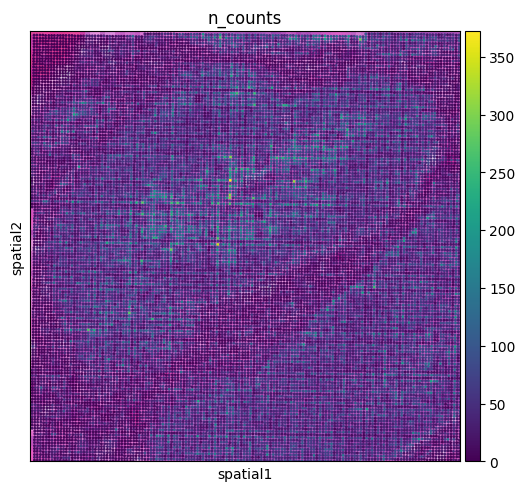

In [7]:
sthdata.adata.obs['n_counts'] = sthdata.adata.X.sum(axis=1)
sq.pl.spatial_scatter(sthdata.adata, crop_coord = coords , color = 'n_counts')

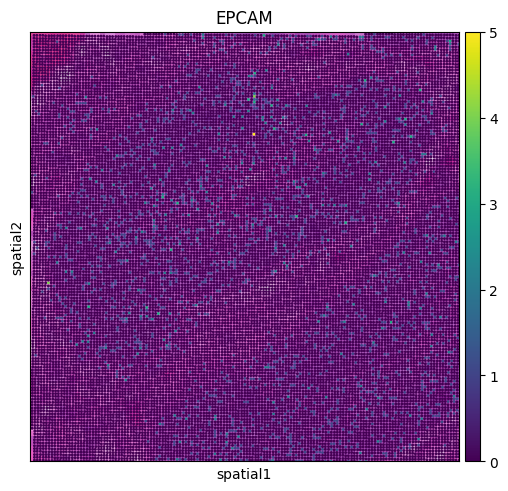

In [8]:
sq.pl.spatial_scatter(sthdata.adata, crop_coord = coords , color = 'EPCAM')

# 2. Patch training

## Fixed best parameters for colon cancer sample

In [9]:
n_iter =  23
beta = 0.1
step_size = 1 # fix

## STHD Training
- Will filter low-count region, train (printing loss for 23 steps), and extract results

In [10]:
# Optional: qc mask to filter low counts; or provide a separate mask
from STHD import qcmask
from STHD import train
sthdata.adata = qcmask.background_detector(sthdata.adata, threshold = 50, n_neighs =4, n_rings = 2)
print(sthdata.adata.shape)
sthdata_filtered = qcmask.filter_background(sthdata, threshold = 50 )
print(sthdata.adata.shape)

# match single cell reference genes
sthdata_filtered, genemeanpd_filtered = train.sthdata_match_refgene(sthdata_filtered, refile)
# model training
P_filtered = train.train(sthdata_filtered, n_iter, step_size, beta)
P = train.fill_p_filtered_to_p_full(P_filtered, sthdata_filtered, genemeanpd_filtered, sthdata )
# model prediction
sthdata = train.predict(sthdata, P, genemeanpd_filtered, mapcut= 0.8)
# results saving to the patch and also extracted to pdata
pdata = train.save_prediction_pdata(sthdata, file_path = patch_path)

(22336, 18085)
[Log] filtering background: 22336 spots to 22120 spots
(22336, 18085)


/hpc/group/yizhanglab/yiz/venv/stvit-cpu/lib64/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


[Log] num of gene overlap 4212
[Log] attaching ref gene expr in .lambda_cell_type_by_gene_matrix
cut 18085 genes to match to reference 4212 genes
[Log] prepare_constants and training weights
Currently we only support symmetric adjacency matrix of neighbors
[Log] Training...
0 150.4049380877398 -144.96462174488178 54.40316342858024
1 144.5123505722058 -138.94634621139178 55.66004360814027
2 139.99419094360377 -134.61415567159503 53.8003527200875
3 136.83813913621933 -131.81646095492434 50.21678181294977
4 134.63075433627398 -130.0102160151146 46.20538321159381
5 133.02954486681148 -128.77310549101114 42.56439375800345
6 131.8049295125207 -127.86921168536627 39.35717827154409
7 130.8273104001446 -127.18449066046894 36.42819739675653
8 130.0024958361374 -126.6339747144767 33.68521121660706
9 129.254901078189 -126.14565001205254 31.09251066136458
10 128.54973405417252 -125.68651247035534 28.632215838171835
11 127.92391770346403 -125.2948843556746 26.29033347789432
12 127.43739524264073 -12

/hpc/group/yizhanglab/yiz/venv/stvit-cpu/lib64/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/group/yizhanglab/yiz/projects/sthd_study/STHDdev/notebooks/../STHD/train.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs["p_ct_" + ct] = p[:, i]
/hpc/group/yizhanglab/yiz/projects/sthd_study/STHDdev/notebooks/../STHD/train.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ada

[Log] prediction saved to ../testdata/crop10/_pdata.tsv


# 3. Ploting
## Squidpy (good for patch size)

/hpc/group/yizhanglab/yiz/venv/stvit-cpu/lib64/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


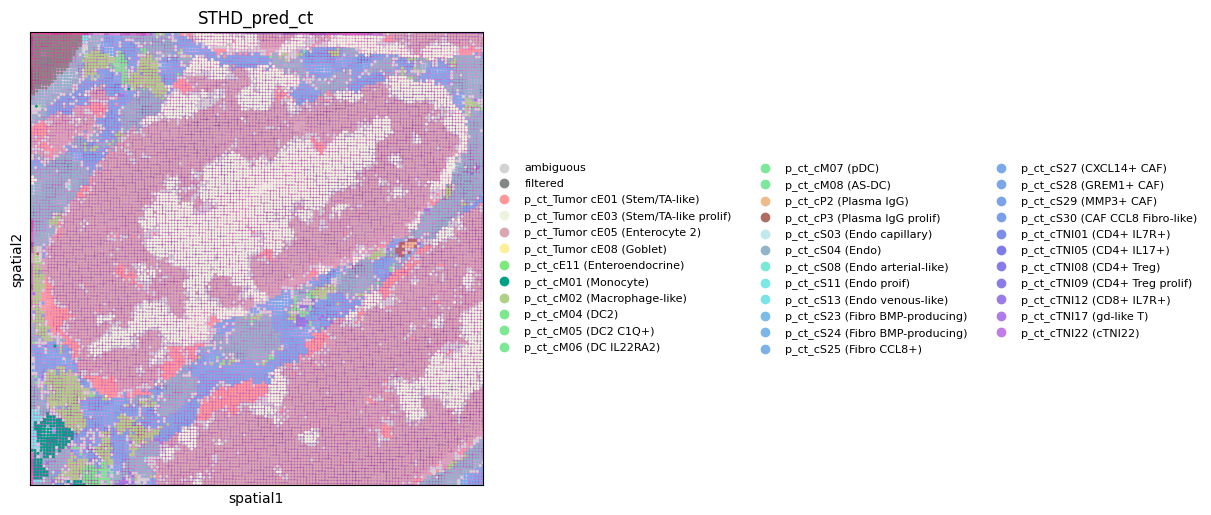

In [11]:
from STHD import color_palette
cmap = color_palette.get_config_colormap( name = 'colormap_coloncatlas_98')
data_palette = color_palette.prepare_palette(cmap, sthdata.adata)

sq.pl.spatial_scatter(sthdata.adata, 
                      color='STHD_pred_ct', 
                      crop_coord = [sthdata.get_sequencing_data_region()],
                      legend_fontsize=8,
                      palette = data_palette,
                      figsize=(12,12)
                    
                     )

# 4. STHDviewer

Advantages compared to traditional scatter plot : 
- Highly optimized for handling millions of points
- Fast and scalable
- Interactive (zoom, pan, selection)
- Results are portable as html files.

In [13]:
from STHD import color_palette
from STHD import sthdviz
from STHD import train

In [19]:
# the training results can be also loaded by the following function
#patch_path = '../testdata/crop10'
#sthdata = train.load_data_with_pdata(file_path = patch_path)

In [15]:
df = sthdata.adata.obs[['array_row', 'array_col', 'STHD_pred_ct']]
df_rasterize = sthdviz.rasterize(df, 'STHD_pred_ct')
sthdviz.fast_plot(
    df_rasterize, 
    title = 'STHDviewer_testpatch',
    save_root_dir = patch_path
)
print(f'html saved to {patch_path}')

1816.0 1966.0 151
2119.0 2269.0 151


convert cell types to numerical representations: 100%|██████████| 151/151 [00:00<00:00, 5073.46it/s]


html saved to ../testdata/crop10


# 5. STHD-guided binning

- If nspot = 4 : 4x4 spots ; each spot 2x2um -> 8x8um bin
- If nspot = 8 : 8x8 spots ; each spot 2x2um -> 16x16um bin

In [16]:
from STHD import binning_fast
binadata = binning_fast.get_sthd_guided_bin_adata(sthdata, pred_col = 'STHD_pred_ct', nspot = 4 )

100%|██████████| 22336/22336 [00:00<00:00, 214476.00it/s]


[LOG] Calculating each bin's sum values


100%|██████████| 3313/3313 [00:02<00:00, 1451.39it/s]


[LOG] Constructing adata.X as a sparse matrix


100%|██████████| 3313/3313 [00:00<00:00, 101567.32it/s]


[Log] binning obs...


100%|██████████| 3313/3313 [00:00<00:00, 5670.06it/s]


[Log] binning obsm...


100%|██████████| 3313/3313 [00:00<00:00, 46986.14it/s]
/hpc/group/yizhanglab/yiz/venv/stvit-cpu/lib64/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/hpc/group/yizhanglab/yiz/projects/sthd_study/STHDdev/notebooks/../STHD/binning_fast.py:335: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  binadata.obs["barcodes_included"] = binadata.obs["barcodes_included"].str.join(


[Log] remove classes to be filtered out...
[Log] filter minimum spot number...
AnnData object with n_obs × n_vars = 2017 × 18085
    obs: 'bin_row', 'bin_col', 'STHD_pred_ct', 'barcodes_included', 'n_counts', 'bin_n_spot'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatial_neighbors', 'STHD_pred_ct_colors'
    obsm: 'spatial'


In [17]:
binadata

AnnData object with n_obs × n_vars = 2017 × 18085
    obs: 'bin_row', 'bin_col', 'STHD_pred_ct', 'barcodes_included', 'n_counts', 'bin_n_spot'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatial_neighbors', 'STHD_pred_ct_colors'
    obsm: 'spatial'

In [18]:
binadata.obs[:5]

,bin_row,bin_col,STHD_pred_ct,barcodes_included,n_counts,bin_n_spot
1852||2179||p_ct_cS27 (CXCL14+ CAF),1852,2179,p_ct_cS27 (CXCL14+ CAF),"s_002um_01855_02181-1,s_002um_01854_02181-1,s_...",404.0,14
1820||2259||p_ct_cS27 (CXCL14+ CAF),1820,2259,p_ct_cS27 (CXCL14+ CAF),"s_002um_01822_02261-1,s_002um_01821_02262-1,s_...",169.0,10
1888||2171||p_ct_Tumor cE03 (Stem/TA-like prolif),1888,2171,p_ct_Tumor cE03 (Stem/TA-like prolif),"s_002um_01891_02172-1,s_002um_01890_02174-1,s_...",1136.0,16
1920||2251||p_ct_Tumor cE05 (Enterocyte 2),1920,2251,p_ct_Tumor cE05 (Enterocyte 2),"s_002um_01921_02251-1,s_002um_01920_02251-1,s_...",511.0,7
1912||2227||p_ct_Tumor cE05 (Enterocyte 2),1912,2227,p_ct_Tumor cE05 (Enterocyte 2),"s_002um_01913_02230-1,s_002um_01912_02229-1,s_...",804.0,16
